# 1_1. 전처리 및 데이터 준비

In [6]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 상관계수 높은 변수 사전 삭제 (전처리 단계)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())



✅ 최종 데이터셋 컬럼 수: 178
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


# 1_2 집단 분류 및 확인 

In [7]:
import pandas as pd
from scipy.stats import skew, kurtosis, ttest_ind

# 0/1 집단 분리
group1 = df[df['sat_group'] == 1]['sat']
group0 = df[df['sat_group'] == 0]['sat']

# 요약 통계 계산
summary = {
    "group": ["전체", "0집단", "1집단"],
    "n": [df['sat'].count(), group0.count(), group1.count()],
    "mean": [df['sat'].mean(), group0.mean(), group1.mean()],
    "std": [df['sat'].std(), group0.std(), group1.std()],
    "skew": [skew(df['sat']), skew(group0), skew(group1)],
    "kurtosis": [kurtosis(df['sat']), kurtosis(group0), kurtosis(group1)]
}

summary_df = pd.DataFrame(summary).round(3)

# t-test (독립표본)
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch’s t-test (이분산 가정)

print("=== sat 요약 통계 ===")
print(summary_df)
print("\n=== 집단 간 T-검정 결과 ===")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


=== sat 요약 통계 ===
  group    n   mean    std   skew  kurtosis
0    전체  355  3.887  0.944 -0.774     0.489
1   0집단  140  2.941  0.680 -1.434     1.807
2   1집단  215  4.502  0.456  0.019    -1.828

=== 집단 간 T-검정 결과 ===
t = 23.903, p = 0.0000


# 1_3 sat KDE그래프 시각화 

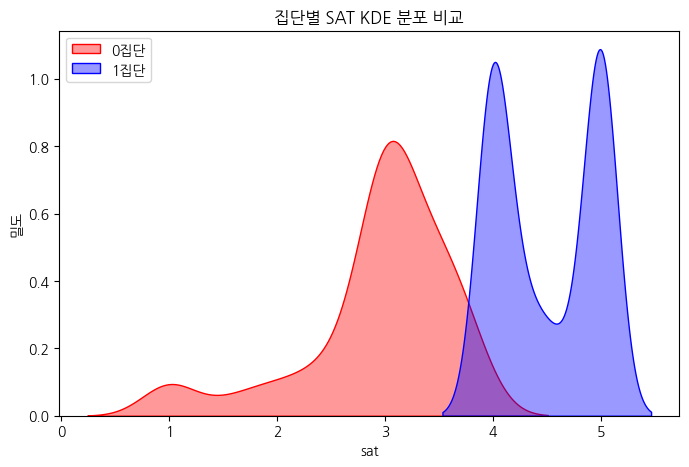

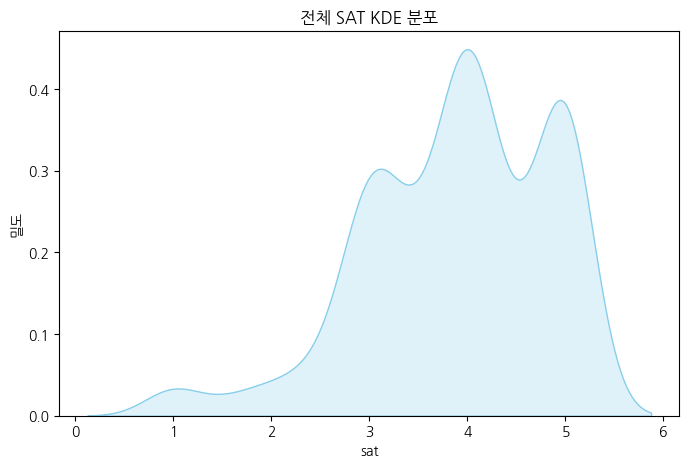

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# ✅ 한글 폰트 설정 (예: 나눔고딕)
plt.rcParams['font.family'] = 'NanumGothic'   # 설치된 다른 한글 폰트 가능
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지

# KDE 그리기
plt.figure(figsize=(8, 5))
sns.kdeplot(group0, fill=True, color="red", alpha=0.4, label="0집단")
sns.kdeplot(group1, fill=True, color="blue", alpha=0.4, label="1집단")
plt.title("집단별 SAT KDE 분포 비교")
plt.xlabel("sat")
plt.ylabel("밀도")
plt.legend()
plt.show()


# 전체 sat KDE 분포
plt.figure(figsize=(8, 5))
sns.kdeplot(df['sat'], fill=True, color="skyblue")
plt.title("전체 SAT KDE 분포")
plt.xlabel("sat")
plt.ylabel("밀도")
plt.show()


# 2_1 변수 선택 + RFECV / ElasticNet 파이프라인

In [9]:
# ======================================
# ✅ 최적화 버전: ElasticNet + RFECV(LR/DT/RF/XGB)
# - 변수 선택은 항상 X_train 내부에서 수행
# - 폴드별 선택 변수 → 교집합(안정적 변수) 추출
# - CV(파이프라인 전체) & Hold-out 평가
# - 중복 코드 최소화, 가독성 강화
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# -------------------------
# 설정
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 존재 확인
# -------------------------
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

# -------------------------
# 타깃/설명변수 설정
# -------------------------
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# -------------------------
# 학습/테스트 분할
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# -------------------------
# CV 설정
# -------------------------
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# -------------------------
# RFECV 파이프라인 생성 함수 
# -------------------------
def make_rfecv_pipeline(base_estimator, final_estimator=None):
    """RFECV 기반 파이프라인 생성"""
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1,
        verbose=0
    )
    # LogisticRegression일 때만 스케일러 추가
    if isinstance(base_estimator, LogisticRegression):
        return Pipeline([("scaler", StandardScaler()),
                         ("feature_selection", rfecv),
                         ("clf", final_estimator)])
    else:
        return Pipeline([("feature_selection", rfecv),
                         ("clf", final_estimator)])

# -------------------------
# 모델 정의
# -------------------------
models = {
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegressionCV(
            Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
            l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
            max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
        ))
    ]),
    "RFECV_LR": make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                    LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)),
    "RFECV_DT": make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                    DecisionTreeClassifier(random_state=RANDOM_STATE)),
    "RFECV_RF": make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                    RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    "RFECV_XGB": make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                     XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                                   use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
}

# -------------------------
# 폴드별 선택 변수 추출
# -------------------------
def extract_fold_selected(pipe_name, pipe):
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]

        if pipe_name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1,.3,.5,.7,.9], scoring="f1",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[enet_fold.coef_.ravel() != 0])
        else:
            # RFECV 모델
            base_map = {
                "RFECV_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                "RFECV_DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
                "RFECV_RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                "RFECV_XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                           eval_metric='logloss', n_jobs=-1)
            }
            rfecv_fold = RFECV(
                estimator=base_map[pipe_name], step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
                n_jobs=1
            )
            rfecv_fold.fit(X_tr, y_tr)
            sel = set(X_tr.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    return fold_sets

selected_per_model = {name: extract_fold_selected(name, pipe) for name, pipe in models.items()}

# -------------------------
# Jaccard 안정성 지수
# -------------------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2: return np.nan
    scores = []
    from itertools import combinations
    for i,j in combinations(range(len(list_of_sets)),2):
        a, b = list_of_sets[i], list_of_sets[j]
        scores.append(1.0 if len(a|b)==0 else len(a&b)/len(a|b))
    return np.mean(scores)

# -------------------------
# CV & Hold-out 평가
# -------------------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring,
                            n_jobs=-1, error_score=np.nan)
    cv_mean = {m: np.nanmean(cv_res[f"test_{m}"]) for m in scoring.keys()}
    cv_std = {m: np.nanstd(cv_res[f"test_{m}"]) for m in scoring.keys()}

    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        try: y_score = fitted_pipe.decision_function(X_test)
        except: y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()
    jacc = mean_pairwise_jaccard(fold_sets)

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])
        except: final_selected = []
    elif name == "ElasticNet":
        try: final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel()!=0])
        except: final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# -------------------------
# 결과 정리
# -------------------------
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "stable_vars": ", ".join(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)

for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    print("안정적 변수:" + (", ".join(r['stable_vars']) if r['stable_vars'] else " 없음"))
    print(f"최종 선택 변수 수: {len(r['final_selected'])}")
    print("최종 선택 변수:" + (", ".join(r['final_selected']) if r['final_selected'] else " 없음"))



===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,n_stable_vars,stable_vars,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,Jaccard
3,RFECV_RF,81,"admin_serv, ask_q, birth_area_chungcheong, bur...",0.866966,0.830890,0.888623,0.886364,0.859155,0.877907,0.762252
0,ElasticNet,17,"course_variety, know_reason, move_univ, peer_a...",0.856121,0.816917,0.889922,0.873563,0.845070,0.858804,0.471099
4,RFECV_XGB,10,"move_univ, peer_event, prof_access, prof_passi...",0.829109,0.792231,0.873803,0.833333,0.802817,0.867940,0.333155
1,RFECV_LR,8,"abroad_practice, edu_doubt, exp_video, has_inc...",0.822550,0.792481,0.871897,0.825000,0.802817,0.862126,0.295061
2,RFECV_DT,0,,0.730870,0.683020,0.673068,0.746988,0.704225,0.699751,0.184756



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수:course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
최종 선택 변수 수: 91
최종 선택 변수:abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_career, peer_class, peer_e

# 3_1. 안정적 변수 기반 모델링 

In [10]:
# ======================================
# ✅ 전체 통합: RFECV/ElasticNet → stable_vars 추출 → 안정적 변수 기반 모델링
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

# ==========================
# 0️⃣ 설정
# ==========================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# df가 이미 전처리 완료 상태라는 가정
try:
    df
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ==========================
# 1️⃣ RFECV/ElasticNet 파이프라인 정의
# ==========================
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[.1, .3, .5, .7, .9], scoring="f1",
        max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

def make_rfecv_pipeline(base_estimator, final_estimator=None):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator, step=1, cv=inner_cv, scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
        n_jobs=1, verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", RFECV(
            estimator=LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
            step=1, cv=inner_cv, scoring='f1',
            min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
            n_jobs=1
        )),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ]),
    "RFECV_DT": make_rfecv_pipeline(
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ),
    "RFECV_RF": make_rfecv_pipeline(
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    ),
    "RFECV_XGB": make_rfecv_pipeline(
        XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                      use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                      use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    )
}

# ==========================
# 2️⃣ 폴드별 선택 변수 추출 (stable_vars)
# ==========================
print(">>> 폴드별 선택 변수 계산 중 ...")
selected_per_model = {}

for name, pipe in models.items():
    fold_sets = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            enet_fold = LogisticRegressionCV(
                Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
                l1_ratios=[.1, .3, .5, .7, .9],
                scoring="f1", max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[enet_fold.coef_.ravel() != 0])
        else:
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                                     eval_metric='logloss', n_jobs=-1)
            rfecv_fold = RFECV(
                estimator=base, step=1, cv=inner_cv, scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])), n_jobs=1
            )
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[rfecv_fold.support_])
        fold_sets.append(sel)
    selected_per_model[name] = fold_sets
    intersec = set.intersection(*fold_sets) if fold_sets else set()
    print(f" - {name}: fold별 선택 수 = {[len(s) for s in fold_sets]}, 교집합(안정적) 수 = {len(intersec)}")

# Jaccard 안정성 지수
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    from itertools import combinations
    scores = [len(list_of_sets[i] & list_of_sets[j]) / len(list_of_sets[i] | list_of_sets[j])
              if len(list_of_sets[i] | list_of_sets[j]) > 0 else 1.0
              for i,j in combinations(range(len(list_of_sets)),2)]
    return np.mean(scores)

# ==========================
# 3️⃣ 파이프라인 전체 CV + Hold-out 평가
# ==========================
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    # CV
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {k: np.nanmean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.nanstd(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out
    fitted_pipe = pipe.fit(X_train, y_train)
    y_pred = fitted_pipe.predict(X_test)
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:,1]
    except:
        y_score = fitted_pipe.decision_function(X_test) if hasattr(fitted_pipe, "decision_function") else None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if fold_sets else set()

    # 최종 선택 변수
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except: final_selected = []
    elif name == "ElasticNet":
        final_selected = list(X_train.columns[fitted_pipe.named_steps['clf'].coef_.ravel() != 0])

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(stable_vars),
        "final_selected": sorted(final_selected)
    })

# ==========================
# 4️⃣ 안정적 변수 기반 최종 모델링
# ==========================
final_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if not stable_vars:
        results_final.append({"source": source, "model": None, "n_features":0})
        continue
    for m_name, clf in final_models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)]) if m_name=="LogReg" else Pipeline([("clf", clf)])
        # CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train, cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
        cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}
        # Hold-out
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try: y_score = pipe.predict_proba(X_test[stable_vars])[:,1]
        except: y_score = pipe.decision_function(X_test[stable_vars])
        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
            "mcc": matthews_corrcoef(y_test, y_pred)
        }
        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}_mean": v for k,v in cv_mean.items()},
            **{f"CV_{k}_std": cv_std[k] for k in scoring},
            **{f"Test_{k}": v for k,v in holdout.items()}
        })

results_final_df = pd.DataFrame(results_final)
print("\n\n=== 안정적 변수 기반 최종 성능표 ===")
display(results_final_df.sort_values(by="CV_f1_mean", ascending=False))

# ==========================
# 5️⃣ 상세 안정적 변수 / 최종 선택 변수 출력
# ==========================
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    if r['stable_vars']: print("안정적 변수 (알파벳순):", ", ".join(r['stable_vars']))
    else: print("안정적 변수: 없음")
    print(f"파이프라인 기반 최종 선택 변수 수: {len(r['final_selected'])}")
    if r['final_selected']: print("최종 선택 변수 (알파벳순):", ", ".join(r['final_selected']))


>>> 폴드별 선택 변수 계산 중 ...
 - ElasticNet: fold별 선택 수 = [30, 30, 62, 63, 24], 교집합(안정적) 수 = 17
 - RFECV_LR: fold별 선택 수 = [16, 58, 55, 53, 59], 교집합(안정적) 수 = 8
 - RFECV_DT: fold별 선택 수 = [131, 8, 10, 157, 46], 교집합(안정적) 수 = 0
 - RFECV_RF: fold별 선택 수 = [144, 156, 128, 82, 149], 교집합(안정적) 수 = 81
 - RFECV_XGB: fold별 선택 수 = [73, 16, 75, 64, 32], 교집합(안정적) 수 = 10

===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 안정적 변수 기반 최종 성능표 ===


,source,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc
11,RFECV_RF,RF,81,0.827444,0.861837,0.896256,0.045001,0.036965,0.033380,0.830986,0.810631,0.866667,0.829787,0.906977,0.877907,0.641850
13,RFECV_XGB,LogReg,10,0.823997,0.859121,0.905440,0.051865,0.039870,0.046934,0.774648,0.770349,0.809524,0.829268,0.790698,0.860050,0.534952
2,ElasticNet,RF,17,0.816855,0.851804,0.901064,0.049290,0.041428,0.043440,0.788732,0.781977,0.823529,0.833333,0.813953,0.893688,0.560703
15,RFECV_XGB,RF,10,0.820301,0.851421,0.882684,0.065459,0.055146,0.056916,0.830986,0.823090,0.860465,0.860465,0.860465,0.897425,0.646179
3,ElasticNet,XGB,17,0.820489,0.850968,0.889023,0.041838,0.038636,0.028696,0.746479,0.747093,0.780488,0.820513,0.744186,0.877907,0.485396
0,ElasticNet,LogReg,17,0.820551,0.850605,0.902116,0.049738,0.047106,0.042281,0.774648,0.776578,0.804878,0.846154,0.767442,0.874585,0.543317
12,RFECV_RF,XGB,81,0.813283,0.848816,0.869650,0.029185,0.024387,0.040721,0.845070,0.840947,0.870588,0.880952,0.860465,0.877907,0.677963
16,RFECV_XGB,XGB,10,0.802757,0.836898,0.874127,0.057215,0.051440,0.038137,0.802817,0.799834,0.833333,0.853659,0.813953,0.898256,0.593296
4,RFECV_LR,LogReg,8,0.792293,0.831643,0.880595,0.038848,0.031964,0.020964,0.704225,0.705980,0.740741,0.789474,0.697674,0.796927,0.403664
9,RFECV_RF,LogReg,81,0.792544,0.828418,0.860255,0.042695,0.037322,0.038844,0.760563,0.771179,0.784810,0.861111,0.720930,0.837209,0.530169



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수 (알파벳순): course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee
파이프라인 기반 최종 선택 변수 수: 91
최종 선택 변수 (알파벳순): abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_early, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_abroad, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_c

# 3_3 9개변수기반 모델링 

In [11]:
# ==========================
# 0️⃣ 고정 변수 그룹 설정
# ==========================
fixed_features = [
    "students_diligent", "move_univ", "peer_event", "prof_access", "prof_passion",
    "student_interact", "study_hard", "theory_cls", "time_eff"
]

X_fixed = df[fixed_features]
y_fixed = df['sat_group']

# Train/Test split
X_train_fixed, X_test_fixed, y_train_fixed, y_test_fixed = train_test_split(
    X_fixed, y_fixed, test_size=0.2, stratify=y_fixed, random_state=RANDOM_STATE
)

# CV 설정
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ==========================
# 1️⃣ 모델 정의
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

fixed_models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))
    ]),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False,
                          eval_metric='logloss', n_jobs=-1)
}

# ==========================
# 2️⃣ CV + Hold-out 평가
# ==========================
results_fixed = []

for m_name, clf in fixed_models.items():
    print(f"\n===== 평가 중: {m_name} =====")
    pipe = clf if m_name != "LogReg" else Pipeline([
        ("scaler", StandardScaler()), ("clf", clf)
    ])

    # CV 평가
    cv_res = cross_validate(pipe, X_train_fixed, y_train_fixed, cv=outer_cv, scoring=scoring, n_jobs=-1)
    cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out 평가
    pipe.fit(X_train_fixed, y_train_fixed)
    y_pred = pipe.predict(X_test_fixed)
    try:
        y_score = pipe.predict_proba(X_test_fixed)[:, 1]
    except:
        y_score = pipe.decision_function(X_test_fixed) if hasattr(pipe, "decision_function") else None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test_fixed, y_pred),
        "balanced_acc": balanced_accuracy_score(y_test_fixed, y_pred),
        "f1": f1_score(y_test_fixed, y_pred),
        "precision": precision_score(y_test_fixed, y_pred, zero_division=0),
        "recall": recall_score(y_test_fixed, y_pred),
        "roc_auc": roc_auc_score(y_test_fixed, y_score) if y_score is not None else np.nan
    }

    results_fixed.append({
        "model": m_name,
        "n_features": len(fixed_features),
        **{f"CV_{k}_mean": v for k, v in cv_mean.items()},
        **{f"CV_{k}_std": cv_std[k] for k in scoring},
        **{f"Test_{k}": v for k, v in holdout_metrics.items()}
    })

# ==========================
# 3️⃣ 복합지표 계산
# ==========================
results_fixed_df = pd.DataFrame(results_fixed)
results_fixed_df["perf_mean"] = round((
    results_fixed_df["Test_f1"] +
    results_fixed_df["Test_roc_auc"] +
    results_fixed_df["Test_balanced_acc"]
) / 3, 3)

results_fixed_df["overfit_gap"] = round((
    np.abs(results_fixed_df["CV_f1_mean"] - results_fixed_df["Test_f1"]) +
    np.abs(results_fixed_df["CV_roc_auc_mean"] - results_fixed_df["Test_roc_auc"]) +
    np.abs(results_fixed_df["CV_accuracy_mean"] - results_fixed_df["Test_balanced_acc"])
) / 3, 3)

total_vars = X_train_fixed.shape[1]
results_fixed_df["var_penalty"] = round(results_fixed_df["n_features"] / total_vars, 3)

results_fixed_df["composite_score"] = round((
    results_fixed_df["perf_mean"]
    - 0.5 * results_fixed_df["overfit_gap"]
    - 0.2 * results_fixed_df["var_penalty"]
), 3)

print("\n=== 고정 변수 9개 모델 복합 성능 지표 ===")
display(results_fixed_df.sort_values(by="composite_score", ascending=False))



===== 평가 중: LogReg =====

===== 평가 중: DT =====

===== 평가 중: RF =====

===== 평가 중: XGB =====

=== 고정 변수 9개 모델 복합 성능 지표 ===


,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,perf_mean,overfit_gap,var_penalty,composite_score
3,XGB,9,0.809774,0.844422,0.863738,0.051658,0.042739,0.047423,0.802817,0.806063,0.829268,0.871795,0.790698,0.893272,0.843,0.016,1.0,0.635
2,RF,9,0.820489,0.853703,0.873020,0.065847,0.052671,0.065111,0.802817,0.799834,0.833333,0.853659,0.813953,0.894103,0.842,0.021,1.0,0.632
0,LogReg,9,0.838095,0.869801,0.900330,0.069503,0.055839,0.053410,0.802817,0.806063,0.829268,0.871795,0.790698,0.874169,0.837,0.033,1.0,0.620
1,DT,9,0.693672,0.738449,0.686366,0.035981,0.032175,0.036398,0.774648,0.776578,0.804878,0.846154,0.767442,0.776578,0.786,0.080,1.0,0.546


In [21]:
# ==========================
# 6️⃣ 고정 변수 9개 기반 모델링 + 복합지표 계산
# ==========================

fixed_features = [
    "students_diligent", "move_univ", "peer_event", "prof_access", "prof_passion",
    "student_interact", "study_hard", "theory_cls", "time_eff"
]

X_fixed = df[fixed_features]
y_fixed = df[target_col]

X_train_fixed, X_test_fixed, y_train_fixed, y_test_fixed = train_test_split(
    X_fixed, y_fixed, test_size=0.2, stratify=y_fixed, random_state=RANDOM_STATE
)

models_fixed = {
    "LogReg": Pipeline([("scaler", StandardScaler()), 
                        ("clf", LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE))]),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

results_fixed = []

for m_name, clf in models_fixed.items():
    print(f"\n===== 평가 중: {m_name} (고정 9개 변수) =====")

    pipe = clf if m_name != "LogReg" else Pipeline([("scaler", StandardScaler()), ("clf", clf)])

    # CV
    cv_res = cross_validate(pipe, X_train_fixed, y_train_fixed, cv=outer_cv, scoring=scoring, n_jobs=-1)
    cv_mean = {k: np.mean(cv_res[f"test_{k}"]) for k in scoring}
    cv_std = {k: np.std(cv_res[f"test_{k}"]) for k in scoring}

    # Hold-out
    pipe.fit(X_train_fixed, y_train_fixed)
    y_pred = pipe.predict(X_test_fixed)
    try:
        y_score = pipe.predict_proba(X_test_fixed)[:, 1]
    except:
        y_score = pipe.decision_function(X_test_fixed) if hasattr(pipe, "decision_function") else None

    holdout_metrics = {
        "Test_accuracy": accuracy_score(y_test_fixed, y_pred),
        "Test_balanced_acc": balanced_accuracy_score(y_test_fixed, y_pred),
        "Test_f1": f1_score(y_test_fixed, y_pred),
        "Test_precision": precision_score(y_test_fixed, y_pred, zero_division=0),
        "Test_recall": recall_score(y_test_fixed, y_pred),
        "Test_roc_auc": roc_auc_score(y_test_fixed, y_score) if y_score is not None else np.nan
    }

    # Overfit gap 계산
    overfit_gap = (
        abs(cv_mean["f1"] - holdout_metrics["Test_f1"]) +
        abs(cv_mean["roc_auc"] - holdout_metrics["Test_roc_auc"]) +
        abs(cv_mean["accuracy"] - holdout_metrics["Test_balanced_acc"])
    ) / 3

    # 변수 복잡도 penalty
    total_vars = X.shape[1]
    var_penalty = len(fixed_features) / total_vars

    # 복합지표 계산
    perf_mean = np.mean([holdout_metrics["Test_f1"], holdout_metrics["Test_roc_auc"], holdout_metrics["Test_balanced_acc"]])
    composite_score = perf_mean - 0.5 * overfit_gap - 0.2 * var_penalty

    results_fixed.append({
        "model": m_name,
        "n_features": len(fixed_features),
        **{f"CV_{k}_mean": cv_mean[k] for k in scoring},
        **{f"CV_{k}_std": cv_std[k] for k in scoring},
        **holdout_metrics,
        "overfit_gap": overfit_gap,
        "var_penalty": var_penalty,
        "perf_mean": perf_mean,
        "composite_score": composite_score
    })

results_fixed_df = pd.DataFrame(results_fixed)
print("\n\n=== 고정 변수 9개 모델 복합 성능 지표 ===")
display(results_fixed_df.sort_values(by="composite_score", ascending=False))



===== 평가 중: LogReg (고정 9개 변수) =====

===== 평가 중: DT (고정 9개 변수) =====

===== 평가 중: RF (고정 9개 변수) =====

===== 평가 중: XGB (고정 9개 변수) =====


=== 고정 변수 9개 모델 복합 성능 지표 ===


,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,overfit_gap,var_penalty,perf_mean,composite_score
3,XGB,9,0.809774,0.844422,0.863738,0.051658,0.042739,0.047423,0.802817,0.806063,0.829268,0.871795,0.790698,0.893272,0.016133,0.052632,0.842868,0.824275
2,RF,9,0.820489,0.853703,0.873020,0.065847,0.052671,0.065111,0.802817,0.799834,0.833333,0.853659,0.813953,0.894103,0.020703,0.052632,0.842423,0.821546
0,LogReg,9,0.838095,0.869801,0.900330,0.069503,0.055839,0.053410,0.802817,0.806063,0.829268,0.871795,0.790698,0.874169,0.032908,0.052632,0.836500,0.809520
1,DT,9,0.693672,0.738449,0.686366,0.035981,0.032175,0.036398,0.774648,0.776578,0.804878,0.846154,0.767442,0.776578,0.079849,0.052632,0.786011,0.735560


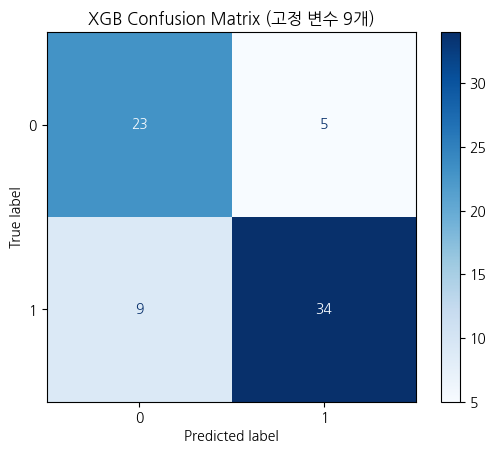

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# XGB 모델 재학습 (고정 변수 9개 기준)
xgb_clf = Pipeline([
    ("clf", XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                          use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
])
xgb_clf.fit(X_train_fixed, y_train_fixed)

# 예측
y_pred_xgb = xgb_clf.predict(X_test_fixed)

# Confusion Matrix 계산
cm = confusion_matrix(y_test_fixed, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)

# 시각화
disp.plot(cmap="Blues")
import matplotlib.pyplot as plt
plt.title("XGB Confusion Matrix (고정 변수 9개)")
plt.show()


# 3_2 복합지표 기반 성능 분석(top10&top3)


=== Top10 후보 모델 (복합 지표 기준) ===
       source   model  n_features  CV_f1_mean   Test_f1  CV_roc_auc_mean  \
0   RFECV_XGB      RF          10    0.851421  0.860465         0.882684   
1  Fixed9Vars     XGB           9    0.843373  0.843373         0.894934   
2  Fixed9Vars      RF           9    0.847059  0.847059         0.895764   
3   RFECV_XGB     XGB          10    0.836898  0.833333         0.874127   
4  Fixed9Vars  LogReg           9    0.829268  0.829268         0.875831   
5  ElasticNet      RF          17    0.851804  0.823529         0.901064   
6  ElasticNet  LogReg          17    0.850605  0.804878         0.902116   
7   RFECV_XGB  LogReg          10    0.859121  0.809524         0.905440   
8  Fixed9Vars      DT           9    0.804878  0.804878         0.776578   
9  ElasticNet      DT          17    0.804347  0.819277         0.754111   

   Test_roc_auc  CV_accuracy_mean  Test_balanced_acc  perf_mean  overfit_gap  \
0      0.897425          0.820301           0.82309

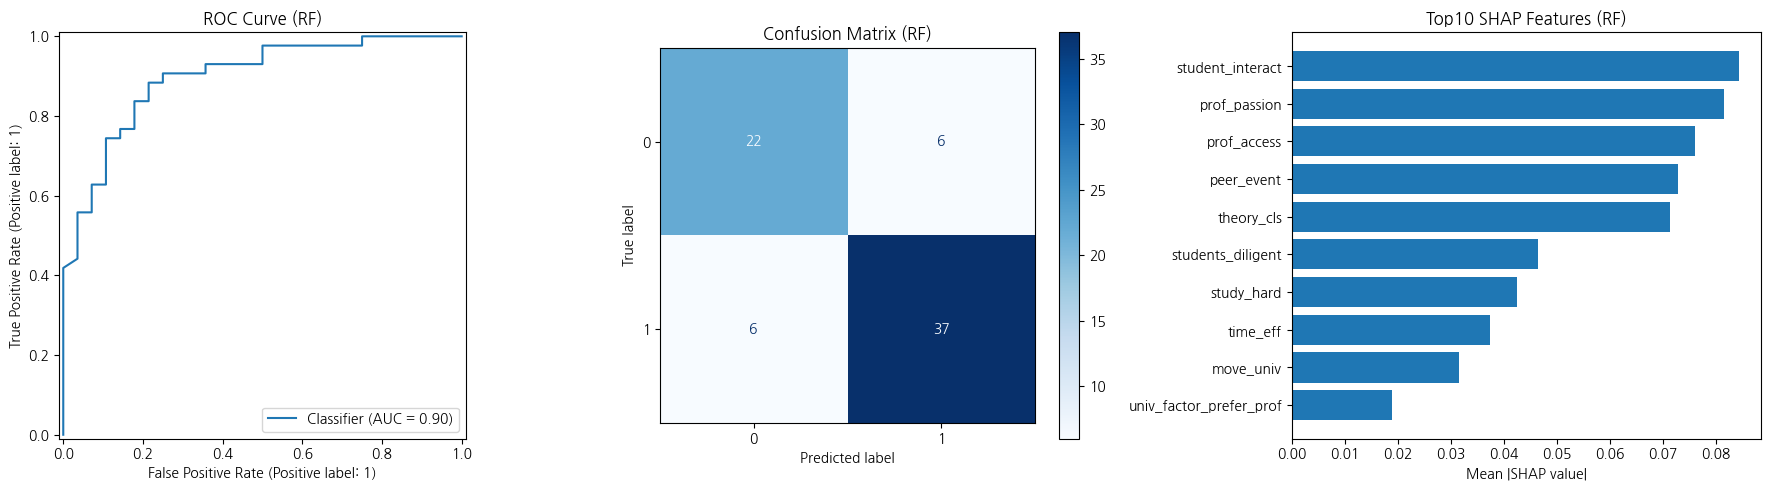

KeyError: 'Fixed9Vars'

In [23]:
# ======================================
# ✅ Top3 안정적 변수 기반 모델 분석 및 Top1 선정
# (복합 지표 + 과적합 + 변수 수 고려 + 안정적 SHAP 계산)
# ======================================
!pip install clf
!pip install shap
import shap
# ------------------------------
# 1️⃣ 복합 지표 계산
# ------------------------------
results_final_df["perf_mean"] = round((
    results_final_df["Test_f1"] +
    results_final_df["Test_roc_auc"] +
    results_final_df["Test_balanced_acc"]
) / 3, 3)

results_final_df["overfit_gap"] = round((
    np.abs(results_final_df["CV_f1_mean"] - results_final_df["Test_f1"]) +
    np.abs(results_final_df["CV_roc_auc_mean"] - results_final_df["Test_roc_auc"]) +
    np.abs(results_final_df["CV_accuracy_mean"] - results_final_df["Test_balanced_acc"])
) / 3, 3)

total_vars = X_train.shape[1]  # 전체 변수 수
results_final_df["var_penalty"] = round(results_final_df["n_features"] / total_vars, 3)

results_final_df["composite_score"] = round((
    results_final_df["perf_mean"]
    - 0.5 * results_final_df["overfit_gap"]
    - 0.2 * results_final_df["var_penalty"]
), 3)

# ------------------------------# ------------------------------
# 2️⃣ Top10 모델 선택
# ------------------------------
top10_df = results_final_df.sort_values(by="composite_score", ascending=False).head(10)
top10_df.reset_index(drop=True, inplace=True)

print("\n=== Top10 후보 모델 (복합 지표 기준) ===")
print(top10_df[["source", "model", "n_features",
                "CV_f1_mean", "Test_f1",
                "CV_roc_auc_mean", "Test_roc_auc",
                "CV_accuracy_mean", "Test_balanced_acc",
                "perf_mean", "overfit_gap", "var_penalty", "composite_score"]])


from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# 3️⃣ Top10 모델 학습 + 평가 지표 출력 (수치만)
# ------------------------------
top1_info = None
for idx, row in top10_df.iterrows():
    source = row["source"]
    model_name = row["model"]
    stable_vars = stable_vars_dict[source]
    clf = final_models[model_name]

    print(f"\n>>> 분석 중: {source} - {model_name} (n_features={len(stable_vars)})")

    # 조건부 스케일링
    if model_name == "LogReg":
        pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    else:
        pipe = Pipeline([("clf", clf)])

    # 학습
    pipe.fit(X_train[stable_vars], y_train)
    y_pred = pipe.predict(X_test[stable_vars])
    try:
        y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
    except:
        y_score = pipe.decision_function(X_test[stable_vars])

    # 성능 지표 계산
    f1 = f1_score(y_test, y_pred)
    acc = balanced_accuracy_score(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, y_score)

    print(f"F1 Score: {f1:.3f}")
    print(f"Balanced Accuracy: {acc:.3f}")
    print(f"ROC AUC: {roc_auc_val:.3f}")

    # 혼동행렬 (수치)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # SHAP 계산
    if model_name in ["RF", "XGB"]:
        explainer = shap.TreeExplainer(pipe.named_steps['clf'])
        shap_values = explainer.shap_values(X_test[stable_vars])
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    elif model_name in ["LogReg", "ElasticNet"]:
        explainer = shap.LinearExplainer(pipe.named_steps['clf'], X_train[stable_vars])
        shap_values = explainer.shap_values(X_test[stable_vars])
    else:
        explainer = shap.Explainer(pipe.named_steps['clf'], X_train[stable_vars])
        shap_values = explainer(X_test[stable_vars]).values

    shap_values_arr = np.array(shap_values)
    if shap_values_arr.ndim > 2:
        shap_values_arr = shap_values_arr[:, :, 0]
    mean_abs_shap = np.abs(shap_values_arr).mean(axis=0)

    shap_df = pd.DataFrame({
        "feature": stable_vars,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False).head(17)

    print("\nTop Features by mean |SHAP|:")
    print(shap_df.to_string(index=False))

    # ===============================
    # ✅ Top3 모델만 시각화 추가
    # ===============================
    if idx < 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # ROC Curve
        RocCurveDisplay.from_predictions(y_test, y_score, ax=axes[0])
        axes[0].set_title(f"ROC Curve ({model_name})")

        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[1], cmap="Blues")
        axes[1].set_title(f"Confusion Matrix ({model_name})")

        # SHAP Bar Plot
        axes[2].barh(shap_df["feature"], shap_df["mean_abs_shap"])
        axes[2].invert_yaxis()
        axes[2].set_title(f"Top10 SHAP Features ({model_name})")
        axes[2].set_xlabel("Mean |SHAP value|")

        plt.tight_layout()
        plt.show()

    # Top1 최종 선정
    if idx == 0:
        top1_info = {
            "source": source,
            "model_name": model_name,
            "stable_vars": stable_vars,
            "pipeline": pipe,
            "y_pred": y_pred,
            "y_score": y_score,
            "shap_df": shap_df
        }


# 3_3 top 3 roc curve 

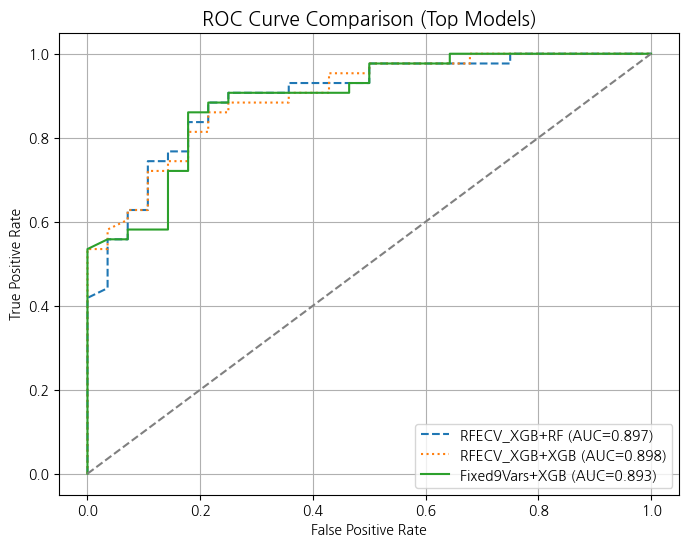

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 1️⃣ RFECV_XGB + RF
rf_clf = final_models["RF"]
rf_clf.fit(X_train[stable_vars_dict["RFECV_XGB"]], y_train)
y_score_rf = rf_clf.predict_proba(X_test[stable_vars_dict["RFECV_XGB"]])[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
auc_rf = roc_auc_score(y_test, y_score_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RFECV_XGB+RF (AUC={auc_rf:.3f})", linestyle="--")

# 2️⃣ RFECV_XGB + XGB
xgb_clf1 = final_models["XGB"]
xgb_clf1.fit(X_train[stable_vars_dict["RFECV_XGB"]], y_train)
y_score_xgb1 = xgb_clf1.predict_proba(X_test[stable_vars_dict["RFECV_XGB"]])[:, 1]
fpr_xgb1, tpr_xgb1, _ = roc_curve(y_test, y_score_xgb1)
auc_xgb1 = roc_auc_score(y_test, y_score_xgb1)
plt.plot(fpr_xgb1, tpr_xgb1, label=f"RFECV_XGB+XGB (AUC={auc_xgb1:.3f})", linestyle=":")

# 3️⃣ Fixed9Vars + XGB
xgb_clf2 = Pipeline([
    ("clf", XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                          use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
])
xgb_clf2.fit(X_train_fixed, y_train_fixed)
y_score_xgb2 = xgb_clf2.predict_proba(X_test_fixed)[:, 1]
fpr_xgb2, tpr_xgb2, _ = roc_curve(y_test_fixed, y_score_xgb2)
auc_xgb2 = roc_auc_score(y_test_fixed, y_score_xgb2)
plt.plot(fpr_xgb2, tpr_xgb2, label=f"Fixed9Vars+XGB (AUC={auc_xgb2:.3f})", linestyle="-")

# 랜덤 기준선
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

plt.title("ROC Curve Comparison (Top Models)", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=10)
plt.grid(True)
plt.show()



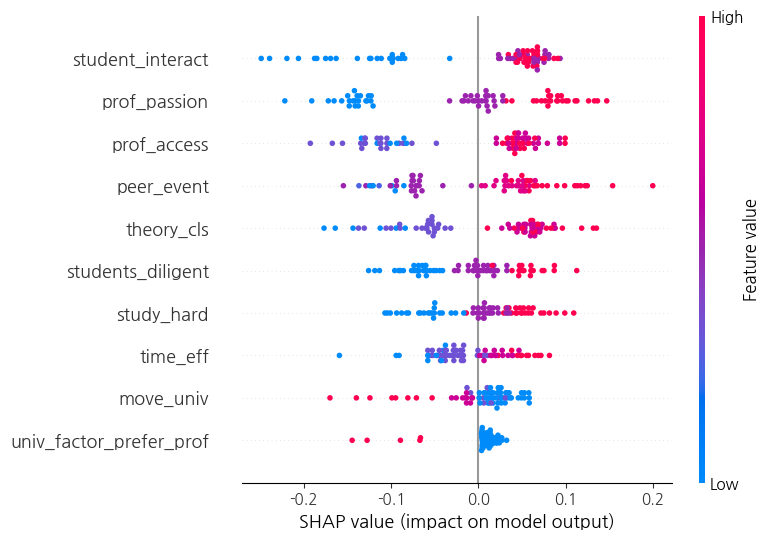

In [46]:
import shap
import matplotlib.pyplot as plt

# 모델 준비
model = final_models["RF"]
stable_vars = stable_vars_dict["RFECV_XGB"]

model.fit(X_train[stable_vars], y_train)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[stable_vars])

# 클래스 1 SHAP 값 선택
if shap_values.ndim == 3 and shap_values.shape[2] == 2:
    shap_values = shap_values[:, :, 1]

# SHAP dot plot
X_test_df = pd.DataFrame(X_test[stable_vars], columns=stable_vars)

shap.initjs()
plt.figure(figsize=(10, 7))
shap.summary_plot(
    shap_values,
    X_test_df,
    plot_type="dot",
    max_display=len(stable_vars)  # 모든 변수 표시
)



In [48]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

# 모델 준비
model = final_models["RF"]
stable_vars = stable_vars_dict["RFECV_XGB"]

model.fit(X_train[stable_vars], y_train)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[stable_vars])

# 클래스 1 SHAP 값 선택
if shap_values.ndim == 3 and shap_values.shape[2] == 2:
    shap_values = shap_values[:, :, 1]

# 변수별 SHAP 평균값 (방향성 포함)
mean_shap_direction = pd.DataFrame({
    "feature": stable_vars,
    "mean_shap": shap_values.mean(axis=0),
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

print("\n=== 변수별 SHAP 방향성 및 절대 평균값 ===")
display(mean_shap_direction)



=== 변수별 SHAP 방향성 및 절대 평균값 ===


,feature,mean_shap,mean_abs_shap
4,student_interact,-0.005516,0.084342
3,prof_passion,-0.012387,0.081511
2,prof_access,-0.013497,0.076131
1,peer_event,0.001655,0.072857
7,theory_cls,0.005646,0.071306
5,students_diligent,-0.010086,0.046425
6,study_hard,0.002744,0.042398
8,time_eff,-0.010846,0.037427
0,move_univ,0.003241,0.031607
9,univ_factor_prefer_prof,0.004985,0.018925


# 4_1 집단 간 검정 

In [50]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# 범주형 변수 교차표
contingency_table = pd.crosstab(df['sat_group'], df['univ_factor_prefer_prof'])
contingency_table.loc['합계'] = contingency_table.sum()

# 수치형 변수 평균 ± 표준편차 계산 및 t-검정
num_vars = ['move_univ', 'peer_event', 'prof_access', 'prof_passion',
            'student_interact', 'students_diligent', 'study_hard',
            'theory_cls', 'time_eff']

summary_list = []
for var in num_vars:
    low_vals = df[df['sat_group']==0][var]
    high_vals = df[df['sat_group']==1][var]
    mean_std_low = f"{low_vals.mean():.3f} ± {low_vals.std():.3f}"
    mean_std_high = f"{high_vals.mean():.3f} ± {high_vals.std():.3f}"
    t_stat, p_val = ttest_ind(low_vals, high_vals, equal_var=False)
    summary_list.append([var, mean_std_low, mean_std_high, round(t_stat, 3), round(p_val, 3)])

# 범주형 변수 카이검정
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table.iloc[:-1, :])

summary_df = pd.DataFrame(summary_list, columns=[
    "Variable", "Low Satisfaction Mean ± Std", "High Satisfaction Mean ± Std", "t", "p-value"
])

# prefer_prof 빈도 및 카이검정 결과 추가
prefer_prof_freq = pd.DataFrame({
    'Variable': ['prefer_prof (freq)'],
    'Low Satisfaction Mean ± Std': [''],
    'High Satisfaction Mean ± Std': [''],
    't': [round(chi2_stat, 3)],
    'p-value': [round(chi2_p, 3)],
    'prefer_prof=0': [contingency_table.loc[0, 0]],
    'prefer_prof=1': [contingency_table.loc[0, 1]],
    '합계': [contingency_table.loc['합계', :].sum()]
})

# 최종 표 결합
final_df = final_df.sort_values(by="p-value", ascending=True)


print(final_df)


NameError: name 'final_df' is not defined

In [5]:
# 전체 변수 목록 출력
all_features = X_train.columns.tolist()
print(all_features)

# 변수 개수 확인
print("전체 변수 개수:", len(all_features))


NameError: name 'X_train' is not defined

In [162]:
import pandas as pd

# X_train: 독립변수 데이터프레임
# y_train: 종속변수 Series (sat)

# 1️⃣ 독립변수 + 타겟 합치기
df_corr = pd.concat([X_train[all_features], y_train.rename("sat")], axis=1)

# 2️⃣ 전체 상관계수 계산
corr_matrix = df_corr.corr(method='pearson')

# 3️⃣ 타겟(sat)과의 상관관계만 추출
sat_corr = corr_matrix["sat"].drop("sat").sort_values(ascending=False)

print(sat_corr)


prof_passion                     0.558
prof_access                      0.500
peer_event                       0.493
course_variety                   0.487
peer_advice                      0.476
student_interact                 0.470
prof_event                       0.464
theory_cls                       0.461
students_diligent                0.457
car_spt                          0.451
peer_external                    0.450
peer_class                       0.446
prac_cls                         0.426
prof_career                      0.426
prof_effort                      0.414
peer_career                      0.410
know_reason                      0.408
admin_serv                       0.400
prof_personal                    0.395
time_eff                         0.394
prof_other_talk                  0.379
prof_grade                       0.374
learn_fun                        0.372
study_hard                       0.368
prof_class_talk                  0.360
try_hard                 

______________________________________#################

In [157]:
# ======================================
# ElasticNet(LogisticRegressionCV) 최적 하이퍼파라미터 확인
# ======================================

# 1) 파이프라인 학습
enet_pipeline.fit(X_train, y_train)

# 2) 최적 하이퍼파라미터 확인
best_Cs = enet_pipeline.named_steps['clf'].C_       # fold별 최적 C 값 (배열)
best_l1  = enet_pipeline.named_steps['clf'].l1_ratio_  # 최적 l1_ratio (배열)

print("ElasticNet 최적 C 값 (fold별):", best_Cs)
print("ElasticNet 최적 l1_ratio (fold별):", best_l1)


ElasticNet 최적 C 값 (fold별): [0.04641589]
ElasticNet 최적 l1_ratio (fold별): [0.1]


In [207]:
nominal_prefixes = [
    "univ_factor", "major_factor", "job_region", "weight_control",
    "birth_area", "housing_type", "enter_type", "major_detail",
    "univ_name", "univ_area", "univ_course_year", "grade", "dance_years"
]

print("=== 명목형 변수 빈도분석 ===")
for prefix in nominal_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        continue
    print(f"\n🔹 {prefix} 변수 그룹")
    for col in cols:
        counts = df[col].value_counts(dropna=False)
        for val, cnt in counts.items():
            percent = cnt / len(df) * 100
            print(f"{col} = {val}: N={cnt}, 비율={percent:.2f}%")



=== 명목형 변수 빈도분석 ===

🔹 univ_factor 변수 그룹
univ_factor = major_apportunity: N=95, 비율=26.76%
univ_factor = social_reputation: N=59, 비율=16.62%
univ_factor = parent_teacher: N=38, 비율=10.70%
univ_factor = commute_near: N=28, 비율=7.89%
univ_factor = edu_structure: N=28, 비율=7.89%
univ_factor = prefer_prof: N=28, 비율=7.89%
univ_factor = grade_fit: N=25, 비율=7.04%
univ_factor = job_prospects: N=13, 비율=3.66%
univ_factor = peer_advice: N=13, 비율=3.66%
univ_factor = low_tuition: N=13, 비율=3.66%
univ_factor = edu_duration: N=7, 비율=1.97%
univ_factor = etc: N=4, 비율=1.13%
univ_factor = total: N=2, 비율=0.56%
univ_factor = in_seoul: N=1, 비율=0.28%
univ_factor = official_univ: N=1, 비율=0.28%

🔹 major_factor 변수 그룹
major_factor = on_interest: N=275, 비율=77.46%
major_factor = career_goals: N=58, 비율=16.34%
major_factor = suggested: N=13, 비율=3.66%
major_factor = job_prospects: N=5, 비율=1.41%
major_factor = early_exp: N=2, 비율=0.56%
major_factor = total: N=1, 비율=0.28%
major_factor = official_univ: N=1, 비율=0.28%

🔹 job_reg

In [208]:
from scipy.stats import chi2_contingency

target = "sat_group"  # 종속변수

chi_results = []

for prefix in nominal_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        continue
    for col in cols:
        # 교차표 (변수 vs sat_group)
        contingency = pd.crosstab(df[col], df[target])
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p, dof, expected = chi2_contingency(contingency)
            chi_results.append([prefix, col, chi2, dof, p])

# 결과를 데이터프레임으로 정리
chi_df = pd.DataFrame(
    chi_results,
    columns=["변수 그룹", "컬럼", "Chi2", "자유도", "p-value"]
).sort_values(by="p-value").reset_index(drop=True)

print(chi_df)


               변수 그룹                컬럼   Chi2  자유도  p-value
0          univ_name         univ_name 45.931   20    0.001
1        univ_factor       univ_factor 28.614   14    0.012
2          univ_area         univ_area  8.557    3    0.036
3         job_region        job_region 11.224    7    0.129
4              grade             grade  4.378    3    0.223
5       major_detail      major_detail  5.973    5    0.309
6       major_factor      major_factor  6.169    6    0.405
7         birth_area        birth_area  6.719    7    0.459
8     weight_control    weight_control  2.192    3    0.534
9   univ_course_year  univ_course_year  0.932    2    0.627
10       dance_years       dance_years  2.239    4    0.692
11        enter_type        enter_type  0.435    2    0.804
12      housing_type      housing_type  0.471    3    0.925


In [203]:
# 빈도분석 결과를 저장할 리스트
freq_list = []

# 명목형 변수 그룹별 빈도분석
nominal_prefixes = [
    "univ_factor", "major_factor", "job_region", "weight_control",
    "birth_area", "housing_type", "enter_type", "major_detail",
    "univ_name", "univ_area", "enter_type"
]

for prefix in nominal_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        continue
    for col in cols:
        counts = df[col].value_counts(dropna=False)
        for val, cnt in counts.items():
            percent = cnt / len(df) * 100
            freq_list.append([prefix, col, val, cnt, percent])

# 데이터프레임 생성
freq_df = pd.DataFrame(freq_list, columns=["변수 그룹", "컬럼", "항목", "빈도(N)", "비율(%)"])

# 보기 좋게 정렬 (같은 컬럼별로 묶기)
freq_df = freq_df.sort_values(
    by=["변수 그룹", "컬럼", "빈도(N)"], 
    ascending=[True, True, False]  # 그룹 → 컬럼 → 빈도순
).reset_index(drop=True)

# 결과 출력
print(freq_df)



             변수 그룹              컬럼                 항목  빈도(N)  비율(%)
0       birth_area      birth_area              seoul    143 40.282
1       birth_area      birth_area           yeongnam    116 32.676
2       birth_area      birth_area              honam     46 12.958
3       birth_area      birth_area        chungcheong     28  7.887
4       birth_area      birth_area             abroad     13  3.662
5       birth_area      birth_area            gangwon      7  1.972
6       birth_area      birth_area               jeju      1  0.282
7       birth_area      birth_area                  g      1  0.282
8       enter_type      enter_type              early    294 82.817
9       enter_type      enter_type              early    294 82.817
10      enter_type      enter_type            regular     36 10.141
11      enter_type      enter_type            regular     36 10.141
12      enter_type      enter_type           transfer     25  7.042
13      enter_type      enter_type           tra

In [205]:
from scipy.stats import chi2_contingency

target = "sat_group"  # 집단 변수
chi_results = []

print("=== 이진형 변수 카이제곱 검정 결과 ===")

for col in binary_cols:
    # 교차표 생성
    contingency = pd.crosstab(df[col], df[target])
    
    if contingency.shape == (2, 2):  # 2x2 교차표만 처리
        chi2, p, dof, expected = chi2_contingency(contingency)
        count_1 = df[col].sum()
        count_0 = (df[col] == 0).sum()
        percent_1 = count_1 / len(df) * 100
        percent_0 = count_0 / len(df) * 100

        chi_results.append([
            col, count_1, percent_1, count_0, percent_0,
            chi2, dof, p
        ])

# 결과를 데이터프레임으로 정리
chi_df = pd.DataFrame(
    chi_results,
    columns=["변수명", "N(1)", "비율(1%)", "N(0)", "비율(0%)", "Chi2", "자유도", "p-value"]
)

# p-value 기준 정렬
chi_df = chi_df.sort_values(by="p-value").reset_index(drop=True)

print(chi_df.head(20))  # 상위 20개만 미리 확인


=== 이진형 변수 카이제곱 검정 결과 ===
                   변수명    N(1)  비율(1%)  N(0)  비율(0%)    Chi2  자유도  p-value
0            sat_group 215.000  60.563   140  39.437 350.825    1    0.000
1       rechoice_major 294.000  82.817    61  17.183  12.833    1    0.000
2        career_course 135.000  38.028   220  61.972   9.447    1    0.002
3           has_income 262.000  73.803    93  26.197   7.619    1    0.006
4        exp_solo_comp 212.000  59.718   143  40.282   4.065    1    0.044
5          info_online  93.000  26.197    90  25.352   4.013    1    0.045
6             job_info  89.000  25.070   266  74.930   2.734    1    0.098
7         exp_concours 139.000  39.155   216  60.845   2.650    1    0.104
8             job_fair  38.000  10.704   317  89.296   2.483    1    0.115
9       has_future_job 207.000  58.310   148  41.690   2.469    1    0.116
10      field_practice 197.000  55.493   158  44.507   2.469    1    0.116
11    income_broadcast  37.000  10.423   146  41.127   2.207    1    0.137

In [210]:
# info_online vs sat_group 교차표
contingency = pd.crosstab(df['univ_name'], df['sat_group'])
print("=== 교차표 ===")
print(contingency)

# 카이제곱 검정
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency)

print("\n=== 카이제곱 검정 결과 ===")
print(f"Chi2: {chi2:.3f}, 자유도: {dof}, p-value: {p:.4f}")
print("\n=== 기대빈도표 ===")
print(pd.DataFrame(expected, 
                   index=contingency.index, 
                   columns=contingency.columns))


=== 교차표 ===
sat_group   0   1
univ_name        
bau        38  50
ccu         7   8
csu         0   1
dau         4   2
ddu         9   3
dku         4   3
dsu         4  12
hyu         5   8
jau        20   7
kju         1   2
kkju        5  11
knsu        0   2
kpu         0   1
pau         2   3
pku         4  33
sau         6  14
sku         4  12
slu         1   1
swu         9   7
wsu         6  11
yu         11  24

=== 카이제곱 검정 결과 ===
Chi2: 45.931, 자유도: 20, p-value: 0.0008

=== 기대빈도표 ===
sat_group      0      1
univ_name              
bau       34.704 53.296
ccu        5.915  9.085
csu        0.394  0.606
dau        2.366  3.634
ddu        4.732  7.268
dku        2.761  4.239
dsu        6.310  9.690
hyu        5.127  7.873
jau       10.648 16.352
kju        1.183  1.817
kkju       6.310  9.690
knsu       0.789  1.211
kpu        0.394  0.606
pau        1.972  3.028
pku       14.592 22.408
sau        7.887 12.113
sku        6.310  9.690
slu        0.789  1.211
swu        6.310  9.

In [193]:
# 이진형 변수 컬럼 확인
binary_cols = [col for col in df.columns if df[col].dropna().value_counts().index.isin([0, 1]).all()]

print("=== 이진형 변수 빈도분석 ===")
for col in binary_cols:
    count_1 = df[col].sum()  # 값이 1인 개수
    count_0 = (df[col] == 0).sum()
    percent_1 = count_1 / len(df) * 100
    percent_0 = count_0 / len(df) * 100
    print(f"{col}: 1 → N={int(count_1)}, 비율={percent_1:.2f}%, 0 → N={int(count_0)}, 비율={percent_0:.2f}%")


=== 이진형 변수 빈도분석 ===
rechoice_major: 1 → N=294, 비율=82.82%, 0 → N=61, 비율=17.18%
has_future_job: 1 → N=207, 비율=58.31%, 0 → N=148, 비율=41.69%
has_income: 1 → N=262, 비율=73.80%, 0 → N=93, 비율=26.20%
has_major_income: 1 → N=189, 비율=53.24%, 0 → N=166, 비율=46.76%
income_class: 1 → N=132, 비율=37.18%, 0 → N=60, 비율=16.90%
income_contest: 1 → N=110, 비율=30.99%, 0 → N=79, 비율=22.25%
income_perf: 1 → N=156, 비율=43.94%, 0 → N=40, 비율=11.27%
income_broadcast: 1 → N=37, 비율=10.42%, 0 → N=146, 비율=41.13%
income_studio: 1 → N=23, 비율=6.48%, 0 → N=163, 비율=45.92%
income_creator: 1 → N=34, 비율=9.58%, 0 → N=154, 비율=43.38%
income_choreo: 1 → N=29, 비율=8.17%, 0 → N=154, 비율=43.38%
info_dept: 1 → N=79, 비율=22.25%, 0 → N=103, 비율=29.01%
info_career_center: 1 → N=18, 비율=5.07%, 0 → N=155, 비율=43.66%
info_online: 1 → N=93, 비율=26.20%, 0 → N=90, 비율=25.35%
info_family: 1 → N=23, 비율=6.48%, 0 → N=154, 비율=43.38%
info_friends: 1 → N=138, 비율=38.87%, 0 → N=51, 비율=14.37%
info_academy: 1 → N=131, 비율=36.90%, 0 → N=55, 비율=15.49%
info_self: 1 → N

In [204]:
from scipy.stats import chi2_contingency

target = "sat_group"  # 집단 변수
chi_results = []

for col in binary_cols:
    # 교차표 생성
    contingency = pd.crosstab(df[col], df[target])
    
    # 카이제곱 검정
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    chi_results.append([col, chi2, dof, p])

# 결과 데이터프레임으로 정리
chi_df = pd.DataFrame(chi_results, columns=["변수명", "Chi2", "자유도", "p-value"])

# p-value 기준 정렬
chi_df = chi_df.sort_values(by="p-value").reset_index(drop=True)

print(chi_df)


                   변수명    Chi2  자유도  p-value
0            sat_group 350.825    1    0.000
1       rechoice_major  12.833    1    0.000
2        career_course   9.447    1    0.002
3           has_income   7.619    1    0.006
4        exp_solo_comp   4.065    1    0.044
5          info_online   4.013    1    0.045
6             job_info   2.734    1    0.098
7         exp_concours   2.650    1    0.104
8             job_fair   2.483    1    0.115
9       has_future_job   2.469    1    0.116
10      field_practice   2.469    1    0.116
11    income_broadcast   2.207    1    0.137
12    career_mentoring   1.810    1    0.179
13             burnout   1.668    1    0.196
14       income_choreo   1.640    1    0.200
15            job_prep   1.634    1    0.201
16          stay_after   1.402    1    0.236
17           exp_video   0.711    1    0.399
18  info_career_center   0.645    1    0.422
19              gender   0.554    1    0.457
20       income_studio   0.452    1    0.502
21       m